# 2023年 世界モデル 第2回演習

この演習では，**ベルヌーイ分布，混合ベルヌーイ分布，混合ガウス分布**を用いてMNISTデータセットをモデリングしていきます．

## 目次

1. [ベルヌーイ分布によるMNIST画像モデリング](#scrollTo=p-KulWxYNbXo)
1. [EMアルゴリズムによる混合ベルヌーイ分布の最適化](#scrollTo=YM49msUsKbkw)
1. [EMアルゴリズムによる混合ガウス分布の最適化](#scrollTo=57Tdk0SEPqQ2)
1. [参考文献](#scrollTo=TWo05r1KEUiR&line=1&uniqifier=1)

In [1]:
# 必要なライブラリのインポート

import copy
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.datasets import mnist
from scipy import stats

%matplotlib inline

In [2]:
def set_seed(seed: int = 1234):
    """
    シード値を設定する関数．
    ここではrandomとNumPyのみですが，他にシード値固定が必要なライブラリがあれば追加する必要があります．

    Parameters
    ----------
    seed : int
        設定するシード値．

    Returns
    -------
    None
    """
    random.seed(seed)
    np.random.seed(seed)


set_seed(0)

In [3]:
# ヘルパー関数の定義


def get_label_idxs(labels: list, t_mnist: np.ndarray) -> np.ndarray:
    """
    MNISTから利用したい数字に対応するデータのindexを取得する関数．

    Parameters
    ----------
    labels : list
        利用したい数字をまとめたリスト．要素は0-9をとることを想定している．
        [0, 3]
    t_mnist : np.ndarray (batch_size, )
        MNSITの教師データ．

    Returns
    -------
    label_ids : np.ndarray (利用するデータの数, )
        リスト内に含まれる数字が正解であるデータのindexをまとめた配列．
    """
    # 長さ60000のt_mnistについて，値が指定したラベルのうちのいずれかであるかのboolean arrayを取ってくる
    label_bool = np.any([t_mnist == label for label in labels], axis=0)
    # Trueである要素のインデックスを得る
    label_idxs = np.where(label_bool)[0]

    return label_idxs


def transforms(data_all: np.ndarray, flatten=True, binarize=True) -> np.ndarray:
    """
    画像データを1次元配列に平坦化し，画素値を{0, 1}に二値化する関数．

    Parameters
    ----------
    data_all : np.ndarray (batch_size, height, width)
        MNISTの入力データ．
    flatten : bool
        入力データを1次元配列にするかどうか判別するフラグ．
        Falseの場合は2次元のまま．
    binarize : bool
        入力データを二値化するかどうか判別するフラグ．
        Falseの場合は[0, 1]に正規化される．

    Returns
    -------
    data_all : np.ndarray (batch_size, height x width)
        平坦化，画素値の二値化を行った結果のデータ．
        flatten=Falseの場合は配列の形が(batch_size, height, width)になる．
        binarize=Falseの場合は画素値が[0, 1]正規化された連続値を取る．
    """
    # 範囲を0~255から0~1にし，平坦化したあと，閾値0.5で0,1のバイナリにする
    data_all = data_all.astype(np.float64) / 255
    if flatten:
        data_all = data_all.reshape((data_all.shape[0], -1))
    if binarize:
        data_all = (data_all > 0.5).astype(np.uint8)

    return data_all

## 1. ベルヌーイ分布によるMNIST画像モデリング

本セクションでは，MNIST画像の1種類のラベルのみを，単純な（多次元）ベルヌーイ分布でモデリングしてみます．

そのために，ここではラベルが1のサンプルのみを600枚取ってきます．

In [4]:
NUM_SAMPLES = 600

(x_mnist, t_mnist), _ = mnist.load_data()
print(f"x_mnist: {x_mnist.shape}, t_mnist: {t_mnist.shape}")

labels = [1]

label_idxs = get_label_idxs(labels, t_mnist)

data_all = x_mnist[label_idxs][:NUM_SAMPLES]
print(f"data_all: {data_all.shape}")

11490434/11490434 [==============================] - 0s 0us/step
x_mnist: (60000, 28, 28), t_mnist: (60000,)
data_all: (600, 28, 28)


最初のサンプルをプロットしてみます．

<Axes: >

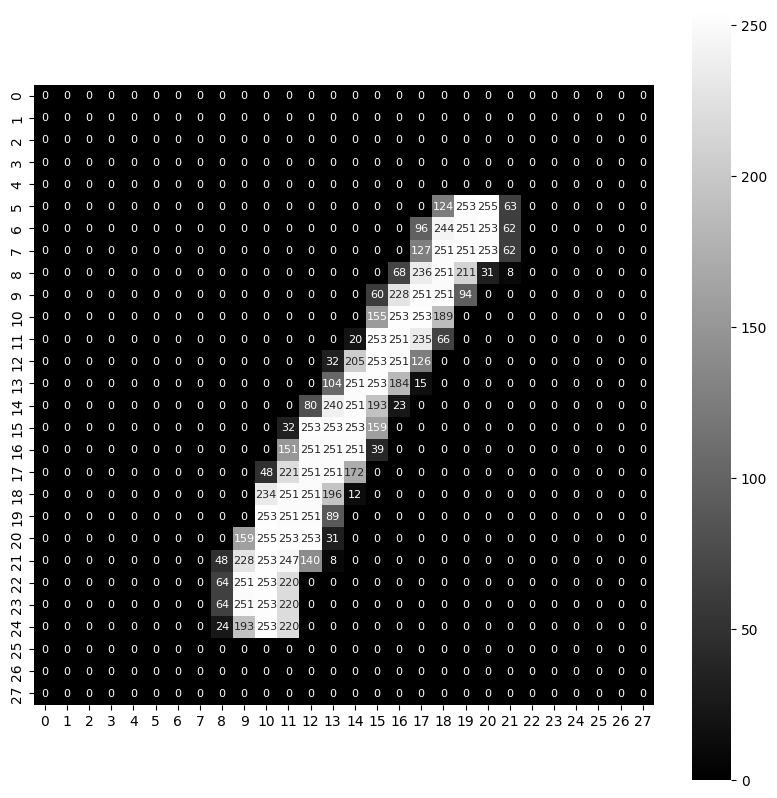

In [5]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    data_all[0],
    cmap="gray",
    annot=True,
    fmt="d",
    annot_kws={"fontsize": 8},
    square=True,
)

多次元ベルヌーイ分布によるモデリングを行うため，ピクセル値の範囲を0-255から0-1にし，{0,1}のバイナリにしてから，データを平坦化します．

In [6]:
binary_data = transforms(data_all)
print(f"binary_data: {binary_data.shape}, set {np.unique(binary_data)}")

binary_data: (600, 784), set [0 1]


あるピクセルについて，値の分布をプロットしてみます．

0の回数:  403
1の回数:  197


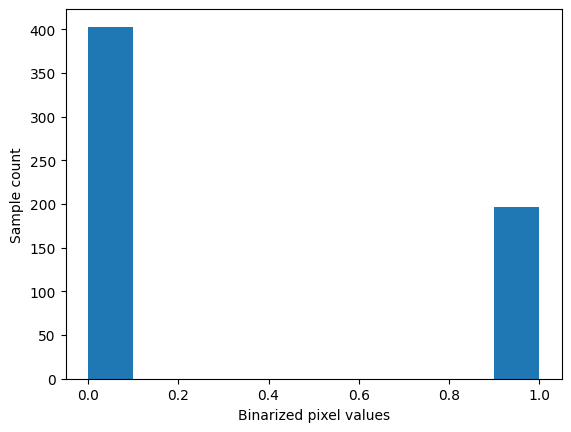

In [7]:
TARGET_PIXEL = 157

binary_pixel = binary_data[:, TARGET_PIXEL]  # ( 600, )

print("0の回数: ", len(binary_pixel) - sum(binary_pixel))
print("1の回数: ", sum(binary_pixel))

plt.hist(binary_pixel)
plt.xlabel("Binarized pixel values")
plt.ylabel("Sample count")
plt.show()

各ピクセルそれぞれに個別のパラメータを持ったベルヌーイ分布が存在すると考えるので，ここでは一つのピクセルについてのみ記述します（つまり$D=784$のインデックスを表す$d$を省略）．

観測データ集合を$X=\left\{x_{i}\right\}_{i=1}^{N}$とします($N=600$)．$x_{i}$は$i$枚目の画像のあるピクセルの値を，閾値0.5で0，1に2値化したものです．

生成モデルの分布としてパラメータが$\mu$のベルヌーイ分布を考え，モデルを設計します．

$$
p_{\mu}({\bf x})=\prod_{i=1}^{N} \mu^{x_{i}}(1-\mu)^{1-x_{i}}
$$

$\mu$の推定量$\hat{\mu}$を最尤推定で求めます．

$$
\hat{\mu}=\underset{\mu}{\operatorname{argmax}} \sum_{i=1}^{N}\left[x_{i} \log \mu+\left(1-x_{i}\right) \log (1-\mu)\right]
$$

対数尤度関数を$\mu$について偏微分してゼロとおくことで，最尤推定量は次のように求まります．

$$
\hat{\mu}=\frac{1}{N}\sum_{i=1}^{N} x_{i}
$$

mu_hats: (784,)
0の回数:  405
1の回数:  195


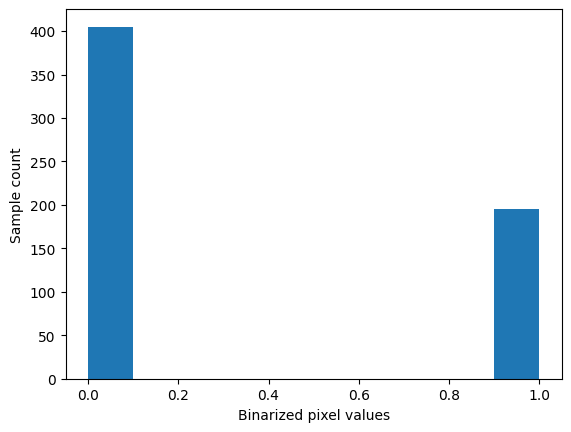

In [8]:
mu_hats = np.mean(binary_data, axis=0)  # ( 784, )
print(f"mu_hats: {mu_hats.shape}")

# TARGET_PIXELのmu_hatをパラメータとするベルヌーイ分布からデータを生成する
sampled_data = stats.bernoulli.rvs(p=mu_hats[TARGET_PIXEL], size=NUM_SAMPLES)
print("0の回数: ", len(sampled_data) - sum(sampled_data))
print("1の回数: ", sum(sampled_data))

plt.hist(sampled_data)
plt.xlabel("Binarized pixel values")
plt.ylabel("Sample count")
plt.show()

ベルヌーイ分布の$\hat{\mu}$を直接可視化してみます．ある程度1を生成するようなパラメータ集合が得られていることがわかります．

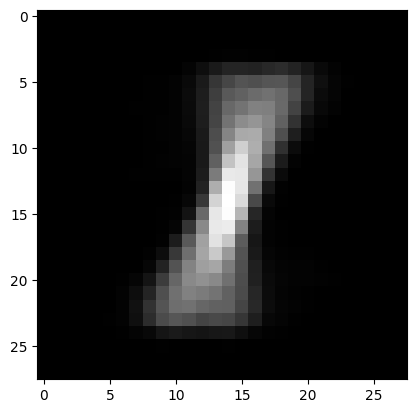

In [9]:
plt.imshow(mu_hats.reshape(28, 28), cmap="gray")

次に，ラベルが0のサンプルを混ぜて，同じ多次元ベルヌーイ分布でモデリングを行ってみます．

data_all: (1200, 28, 28)
binary_data: (1200, 784), set [0 1]
mu_hats: (784,)


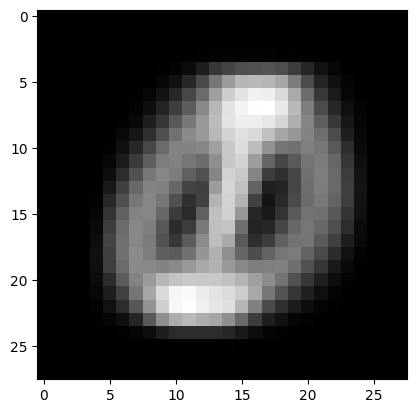

In [10]:
NUM_SAMPLES = 1200

labels = [0, 1]

label_idxs = get_label_idxs(labels, t_mnist)
data_all = x_mnist[label_idxs][:NUM_SAMPLES]
print(f"data_all: {data_all.shape}")

binary_data = transforms(data_all)
print(f"binary_data: {binary_data.shape}, set {np.unique(binary_data)}")

# 最尤推定
mu_hats = np.mean(binary_data, axis=0)  # ( 784, )
print(f"mu_hats: {mu_hats.shape}")

plt.imshow(mu_hats.reshape(28, 28), cmap="gray")

0とも1とも言えない画像を生成するようなパラメータが得られてしまいました．

データのソースに明らかに複数の確率分布が考えられる場合は，混合分布が有用です．

しかし，講義でもあったように，混合分布では対数尤度関数でlogの中に和の形があるため，上記のような閉形式で（微分してゼロとおくようなアプローチで）最尤推定を行うことができません．

そこで次に，**EMアルゴリズム**[[1]](#scrollTo=TWo05r1KEUiR&line=2&uniqifier=1)によって混合ベルヌーイ分布を最適化することを考えていきます．

## 2. EMアルゴリズムによる混合ベルヌーイ分布の最適化

### 2.1 問題設定

本セクションでは，混合ベルヌーイ分布を用いてMNISTデータセットをモデリングしていきます．

以下では，ラベルが **0, 5, 7** の画像を合わせて1800枚用います．

観測データ集合は${\bf X}=\left\{{\bf x}_{i}\right\}_{i=1}^{N}$（ただし$N=1800$）．${\bf x}_i$は2値化された$i$枚目の画像（長さ784のベクター）です．

$K(=3)$個のラベルのうち，どのラベルの画像の値かを示す**潜在変数**を$\mathbf{z}=\left[z_1, z_2, z_3\right]^{T} \in\{0,1\}^3$とします．

- つまり$\mathbf{z}$は長さ$K$のone-hotベクトルで，${\sum_{k=1}^{K} z_{k}=1},\quad z_k \in \{0,1\}$

- $\mathbf{z} = [1, 0, 0]$ならラベルが0の画像を表す

$\mathbf{z}$が従う確率分布をカテゴリ分布とし，$z_k = 1$となる確率を$\pi_{k}$とします．

- $\sum_{k=1}^{K}\pi_{k}=1\qquad \pi_{k} \in[0,1]$

- カテゴリ分布の確率質量関数　$p_{\pi}(\mathbf{z})=\prod_{k=1}^{K} \pi_{k}^{z_{k}}$

### 2.2 混合ベルヌーイ分布の復習

- 講義スライドの「潜在変数モデルと混合モデル」を参照してください．

ある潜在変数${\bf z}$を選んだ上で，確率変数$x$が従う確率分布は，

$$
p_{\mu}(x|{\bf z}) = \prod_{k=1}^K\left\{ \mu_k^x(1-\mu_k)^{1-x}\right\}^{z_k}
$$

- $z_k=1$となる$k$以外は$z_k=0$となるので，積に影響しない．

同時分布

$$
p_{\mu,\pi}(x,{\bf z}) = p_{\mu}(x|{\bf z})p_{\pi}({\bf z})
= \prod_{k=1}^K \left\{ \pi_k \mu_k^x (1-\mu_k)^{1-x} \right\} ^{z_k}
$$

周辺分布

$$
p_{\mu,\pi}(x) = \sum_z p_{\mu,\pi}(x,{\bf z})
= \sum_{k=1}^K p_{\mu,\pi}(x,z_k=1)
= \sum_{k=1}^K\pi_k\mu_k^x (1-\mu_k)^{1-x}
$$

$x$の周辺分布は，ベルヌーイ分布の線形和で表されることがわかりました．

この対数周辺尤度を最大化するようなパラメータ${\mu_k},{\pi_k}$を求めるために，EMアルゴリズムを用いて最適化を行っていきます．

In [11]:
NUM_SAMPLES = 1800

(x_mnist, t_mnist), _ = mnist.load_data()
print(f"x_mnist: {x_mnist.shape}, t_mnist: {t_mnist.shape}")

labels = [0, 5, 7]

label_idxs = get_label_idxs(labels, t_mnist)

data_all = x_mnist[label_idxs][:NUM_SAMPLES]
print(f"data_all: {data_all.shape}")

# 範囲を0~255から0~1にし，平坦化したあと，閾値0.5で0,1のバイナリにする
binary_data = transforms(data_all)
print(f"binary_data: {binary_data.shape}")

x_mnist: (60000, 28, 28), t_mnist: (60000,)
data_all: (1800, 28, 28)
binary_data: (1800, 784)


#### 多次元ベルヌーイ分布の対数尤度

1枚の画像について，多次元ベルヌーイ分布の確率質量関数は以下のようになります．$D$はピクセル数で，MNISTの場合は784です．（$d$の添字が$\mu$にもついていることに注意してください．）

$$
p_\mu({\bf x}) = \prod_{d=1}^D\mu_d^{x_d}(1-\mu_d)^{1-{x_d}}
$$

対数をとると，

$$
{\rm log}\ p_\mu({\bf x}) = \sum_{d=1}^D \left\{x_d\ {\rm log\ }\mu_d + (1 - x_d)\ {\rm log\ }(1 - \mu_d)\right\}
$$

In [16]:
# float型では、（大体）1e-323未満の値は精度の問題で0.0となり、
# 対数を取ると -inf となるので下限を抑えておく
def np_log(x: np.ndarray) -> np.ndarray:
    """
    配列内の要素が-infにならないように下限を設定する．

    Parameters
    ----------
    x : np.ndarray
        要素をクリッピングする対象の配列．形状に指定はない．

    Returns
    -------
    x : np.ndarray
        要素をクリッピングしたあとの配列．最小値が1e-323，最大値が1e+10にされる．
    """
    return np.log(np.clip(a=x, a_min=1e-323, a_max=1e10))


# ベルヌーイ分布の対数尤度を計算する関数
def log_bernoulli_density(x: np.ndarray, mu: np.ndarray) -> float:
    """
    ベルヌーイ分布の対数尤度を計算する関数．
    各ピクセルに対するベルヌーイ分布の対数尤度を計算した総和を取る．

    Parameters
    ----------
    x : np.ndarray (784, )
        MNISTの入力データ．平坦化されていることを想定している．
    mu : np.ndarray (784, )
        各ピクセルに対するベルヌーイ分布のパラメータ（平均値）．

    Returns
    -------
    log_p : float
        多次元ベルヌーイ分布の対数尤度．
    """
    log_p = x * np_log(mu) + (1 - x) * np_log(1 - mu)  # ( 784, )
    log_p = np.sum(log_p)
    return log_p

### 2.3 全データに対する，混合ベルヌーイ分布の対数尤度

データ（画像）の数を$N$，混合数を$K$，各ベルヌーイ分布を$p_{\mu_k}(x)$とすると，全データ点に対する混合ベルヌーイ分布の対数尤度は，以下で表されます．

$$
{\rm log}\  p_\mu(X)= \sum_{i=1}^N{\rm log}\sum_{k=1}^K\pi_k p_{\mu_k}({\bf x}_i)
$$
<!--\quad\left( = \sum_{i=1}^N\log\sum_{k=1}^K\pi_k\mu_k^{x_i}(1-\mu_k)^{1-x_i} \right) -->

In [13]:
def log_likelihood(
    binary_data: np.ndarray, mu_list: np.ndarray, pi_list: np.ndarray
) -> float:
    """
    全てのデータ点を用いた，混合ベルヌーイ分布に対する対数尤度を計算する関数．

    Parameters
    ----------
    binary_data : np.ndarray (NUM_SAMPLES, 784)
        すべてのデータ点をまとめた配列．
    mu_list : list [ (784), (784), (784) ]
        各ピクセルのベルヌーイ分布のパラメータ（平均値）．
    pi_list : np.ndarray (3, )
        混合率をまとめた配列．

    Returns
    -------
    log_likely_all : float
        混合ベルヌーイ分布に対する対数尤度．
    """
    # binary_data: ( 1800, 784 ), mu_list: [ (784), (784), (784) ], pi_list: ( 3, )
    log_likely_all = 0
    for data in binary_data:
        likely = 0
        for k in range(len(pi_list)):
            likely += pi_list[k] * np.exp(log_bernoulli_density(data, mu_list[k]))
        log_likely_all += np_log(likely)

    return log_likely_all

### 2.4 負担率

負担率は，各データ点が与えられた上での潜在変数（カテゴリ）の事後確率を指します．

負担率を計算することは，各データ点がどのカテゴリからサンプリングされたかを推論することに相当します．

任意のピクセルに対し，$i$番目のデータ（画像）に対する，$k$番目の潜在変数を$z_{ik}$とすると，負担率は以下で表されます．

<!--$$
p_{\mu,\pi}(z_{ik}=1 | {\bf x}_i)
= \frac{p_{{\mu_k},{\pi_k}}({\bf x}_i,z_{ik}=1)}{\sum_{j=1}^K p_{{\mu_j},{\pi_j}}({\bf x}_i, z_{ik}=1)}
=\frac{\pi_k \mu_k^{{\bf x}_i}(1-\mu_k)^{1-{\bf x}_i}}{\sum_{j=1}^K\pi_j \mu_j^{{\bf x}_i}(1-\mu_j)^{1-{\bf x}_i}}
\equiv \gamma(z_{ik})
$$-->

$$
p_{\mu,\pi}(z_{ik}=1 | {\bf x}_i)
= \frac{p_{{\mu},{\pi}}({\bf x}_i,z_{ik}=1)}{\sum_{z} p_{\mu,\pi}({\bf x}_i, z_{ik}=1)}
=\frac{\pi_k\ p_{\mu_k}({\bf x}_i)}{\sum_{j=1}^K\pi_j\ p_{\mu_j}({\bf x}_i)}
\equiv \gamma(z_{ik})
$$

In [14]:
def responsibility(data_all: np.ndarray, mu_list: list, pi_list: list) -> np.ndarray:
    """
    負担率を計算する関数．

    Parameters
    ----------
    binary_data : np.ndarray (NUM_SAMPLES, 784)
        すべてのデータ点をまとめた配列．
    mu_list : list [ (784), (784), (784) ]
        各ピクセルのベルヌーイ分布のパラメータ（平均値）．
    pi_list : list (3, )
        混合率をまとめた配列．

    Returns
    -------
    gamma_mat : np.ndarray
        各データに対する負担率．
    """
    gamma_mat = np.zeros((data_all.shape[0], len(pi_list)))  # ( 1800, 3 )
    for i in range(gamma_mat.shape[0]):
        for k in range(gamma_mat.shape[1]):
            gamma_mat[i][k] = log_bernoulli_density(data_all[i], mu_list[k])
        # オーバーフローを防ぐため
        gamma_mat[i] -= np.max(gamma_mat[i])
        gamma_mat[i] = pi_list * np.exp(gamma_mat[i])
        gamma_mat[i] /= np.sum(gamma_mat[i])
    return gamma_mat

### 2.5 学習

EMアルゴリズムによる学習は，EステップとMステップを繰り返すことで最適化を行います．

1. Eステップ  
現在のパラメータのもとで，事後分布（負担率）を計算する．　$\gamma(z_{ik})=p_{\mu,\pi}(z_{ik}=1|{\bf x}_i)$

1. Mステップ  
負担率を用いて，新しいパラメータ$\mu_k$と$\pi_k$を推定して更新する．

混合ベルヌーイ分布ではMステップにおける更新式は以下となります(証明等はテキストを参照してください)

$$
\hat\pi_k = \frac{N_k}{N}\qquad
\hat\mu_k = \frac{1}{N_k} \sum_{i=1}^N\gamma(z_{ik})x_i
\qquad ただし，N_k = \sum_{i=1}^N\gamma(z_{ik})
$$

$\hat\pi_k$は全データの負担率の平均値，$\hat\mu_k$は負担率による重み付きサンプル平均に相当します．

EMアルゴリズムでは，各ステップごとの対数尤度が非減少であることが保証されており，増加幅が一定値以下となったら収束したとみなして，学習を終了します．

Iteration: 0, log_likelihood: -740.2503645809184


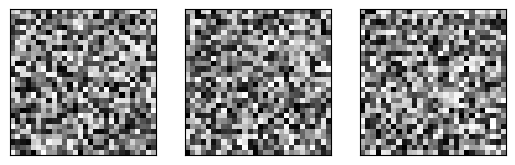

Iteration: 1, log_likelihood: -198.50624250983913
pi_list: [0.25019486152030274, 0.7487840417519364, 0.0010210967277609448]


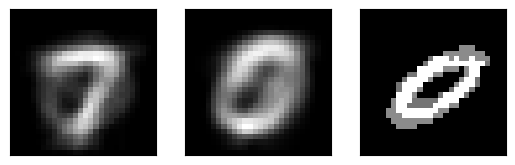

Iteration: 2, log_likelihood: -190.22877215926917
pi_list: [0.3851661450355957, 0.6137227438532932, 0.0011111111111111118]


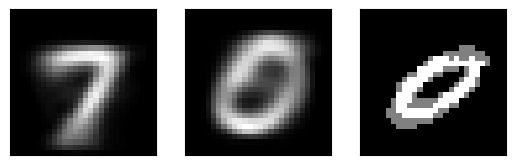

Iteration: 3, log_likelihood: -189.95711627732678
pi_list: [0.4043161584213608, 0.5945727304675281, 0.001111111111111111]


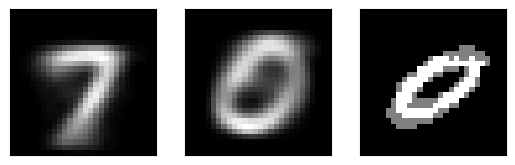

Iteration: 4, log_likelihood: -189.67190804068025
pi_list: [0.42121120288437114, 0.5776776860045177, 0.001111111111111111]


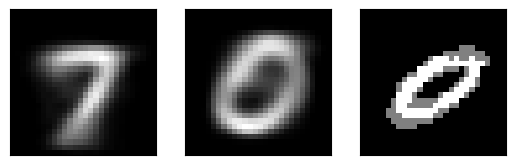

Iteration: 5, log_likelihood: -189.27787811396857
pi_list: [0.4430161147842902, 0.5558727741045987, 0.001111111111111111]


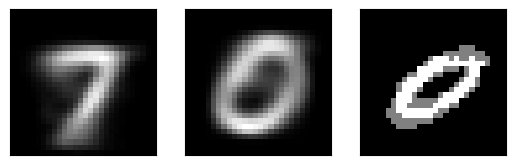

Iteration: 6, log_likelihood: -189.08448682571694
pi_list: [0.46157945646645177, 0.537309432422437, 0.0011111111111111111]


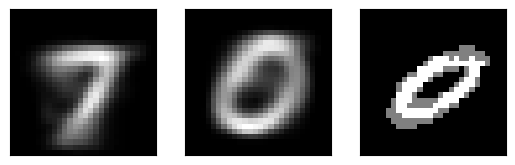

Iteration: 7, log_likelihood: -188.9879171123614
pi_list: [0.47167919678445863, 0.5272096921044302, 0.0011111111111111113]


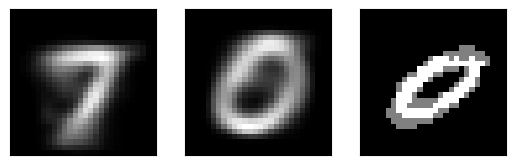

Iteration: 8, log_likelihood: -188.88951610026302
pi_list: [0.4771212748772059, 0.521767614011683, 0.0011111111111111111]


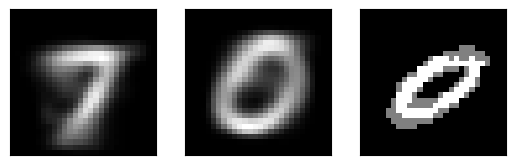

Iteration: 9, log_likelihood: -188.8190430880761
pi_list: [0.4847017469450976, 0.5141871419437913, 0.0011111111111111111]


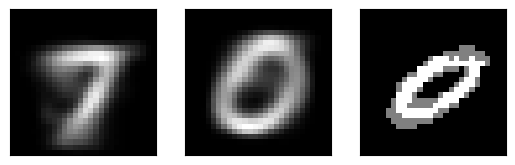

Iteration: 10, log_likelihood: -188.81237912989099
pi_list: [0.4886395835112012, 0.5102493053776878, 0.0011111111111111111]


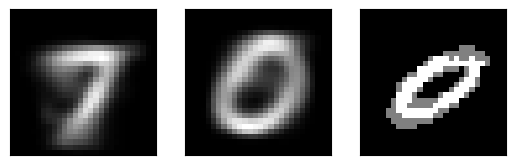

Iteration: 11, log_likelihood: -188.77612975973145
pi_list: [0.48980880411330713, 0.5090800847755818, 0.0011111111111111111]


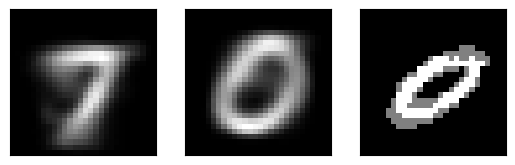

Iteration: 12, log_likelihood: -188.70965947183163
pi_list: [0.49244059572648424, 0.5064482931624046, 0.0011111111111111111]


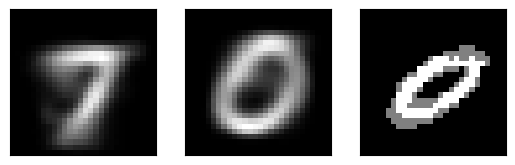

Iteration: 13, log_likelihood: -188.70645199473398
pi_list: [0.49441686196870793, 0.5044720269201809, 0.0011111111111111111]


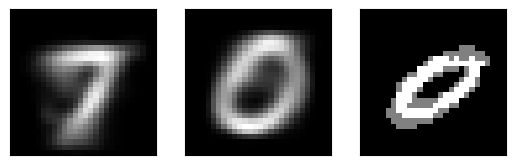

Iteration: 14, log_likelihood: -188.70619272037916
pi_list: [0.49501202113107423, 0.5038768677578147, 0.0011111111111111111]


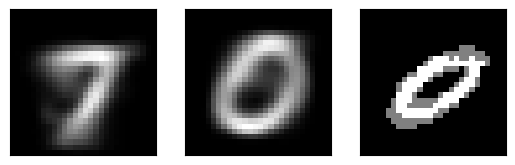

Iteration: 15, log_likelihood: -188.70617162832542
pi_list: [0.4951905201548966, 0.5036983687339923, 0.0011111111111111111]


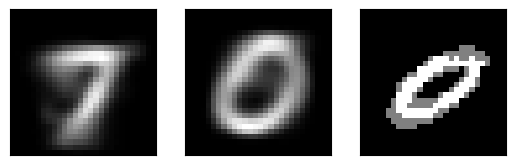

Iteration: 16, log_likelihood: -188.70616961209578
pi_list: [0.4952442010349716, 0.5036446878539174, 0.0011111111111111111]


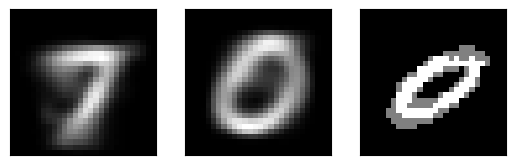

Iteration: 17, log_likelihood: -188.70616938445565
pi_list: [0.4952613987070393, 0.5036274901818496, 0.0011111111111111111]


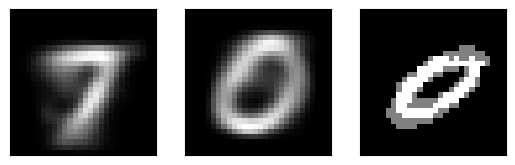

Iteration: 18, log_likelihood: -188.70066303825516
pi_list: [0.49526712100678555, 0.5036217678821034, 0.0011111111111111111]


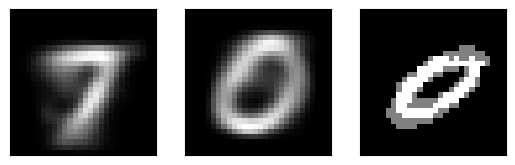

Iteration: 19, log_likelihood: -188.6672015313045
pi_list: [0.4963734312879455, 0.5025154576009434, 0.0011111111111111111]


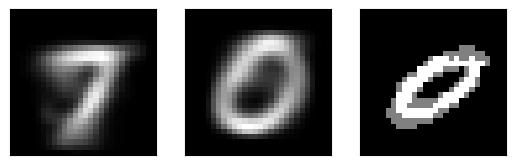

Iteration: 20, log_likelihood: -188.65007690036336
pi_list: [0.4990424810377502, 0.49984640785113876, 0.0011111111111111111]


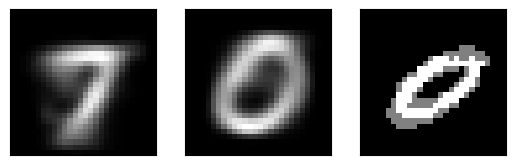

Iteration: 21, log_likelihood: -188.64348073250935
pi_list: [0.5004492292677346, 0.4984396596211543, 0.0011111111111111111]


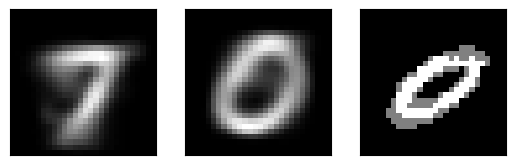

Iteration: 22, log_likelihood: -188.6433510842832
pi_list: [0.5009528928814395, 0.49793599600744937, 0.0011111111111111111]


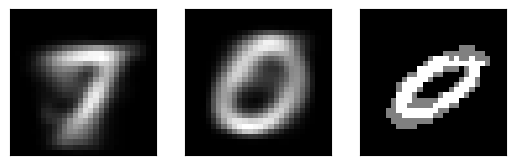

In [19]:
# 各ベルヌーイ分布のパラメータを適当な値で初期化
mu_list = [np.random.rand(binary_data.shape[1]) for _ in labels]  # それぞれ ( 784, )

# 混合分布の重みを初期化
pi_list = [0.3, 0.3, 0.4]

# 更新回数を格納する変数
n_iter = 0

# 現在のパラメータを用いて全データに対する対数尤度を計算
likely = log_likelihood(binary_data, mu_list, pi_list) / binary_data.shape[0]
print("Iteration: {0}, log_likelihood: {1}".format(n_iter, likely))

fig = plt.figure()
for i in range(len(mu_list)):
    ax = fig.add_subplot(1, len(mu_list), i + 1, xticks=[], yticks=[])
    ax.imshow(mu_list[i].reshape(28, 28), "gray")
plt.show()

# 対数尤度の上がり幅がth以下になったら収束したと判定する
th = 0.001

# 学習
while True:
    n_iter += 1

    # Eステップ：現在のパラメータのもとでの事後分布（負担率）を計算
    gamma_mat = responsibility(binary_data, mu_list, pi_list)  # ( 1800, 3 )
    n_k = np.sum(gamma_mat, axis=0)  # ( 3, )

    # Mステップ：負担率を用いて，新しいパラメータを推定・更新
    # piの新しい推定量
    pi_list_next = (n_k / n_k.sum()).tolist() # .tolist()

    # gamma_mat: ( 1800, 3 ) binary_data: ( 1800, 784 ) n_k: ( 3, )
    mu_list_next = (binary_data.T @ gamma_mat / n_k).T  # ( 3, 784 )
    # muの新しい推定量．0次元目だけリストになる
    mu_list_next = list(mu_list_next)  # [( 784, ), ( 784, ), ( 784, )]

    mu_list = copy.deepcopy(mu_list_next)
    pi_list = copy.deepcopy(pi_list_next)

    likely_before = likely

    likely = log_likelihood(binary_data, mu_list, pi_list) / binary_data.shape[0]

    print("Iteration: {0}, log_likelihood: {1}".format(n_iter, likely))

    delta = likely - likely_before

    print("pi_list: {}".format(pi_list))
    # print("mu_list avg: {}".format([mu.mean() for mu in mu_list]))

    fig = plt.figure()
    for i in range(len(mu_list)):
        ax = fig.add_subplot(1, len(mu_list), i + 1, xticks=[], yticks=[])
        ax.imshow(mu_list[i].reshape(28, 28), "gray")
    plt.show()

    if delta < th and n_iter > 20:
        break

最後に，最適化したパラメータのベルヌーイ分布からサンプリングを行ってみます．

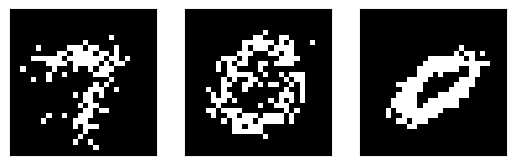

In [20]:
sampled_data = [np.random.binomial(n=1, p=mu) for mu in mu_list]

fig = plt.figure()
for i, sample in enumerate(sampled_data):
    ax = fig.add_subplot(1, len(mu_list), i + 1, xticks=[], yticks=[])
    ax.imshow(sample.reshape(28, 28), "gray")
plt.show()

## 3. EMアルゴリズムによる混合ガウス分布の最適化

### 3.1 問題設定

本セクションで用いるデータは，人工的に生成した2次元混合ガウス分布によるデータです．

先ほどの混合ベルヌーイ分布ではデータは784次元でしたが，今回2次元データを用いるのは，各学習ステップにおける分布の変化をわかりやすく可視化するためです．

In [21]:
# データ分布（混合ガウス分布）を定義してデータを生成する

mu0_data = np.array([0, -0.5])
sigma0_data = np.array([[1.0, 0], [0, 1.0]])

mu1_data = np.array([2.5, 2])
sigma1_data = np.array([[0.5, 0.3], [0.3, 0.7]])

mu2_data = np.array([-2, 1.5])
sigma2_data = np.array([[1.2, 0.2], [0.2, 0.4]])

mu_data_list = [mu0_data, mu1_data, mu2_data]
sigma_data_list = [sigma0_data, sigma1_data, sigma2_data]
sigma_data_inv_list = [np.linalg.inv(sigma) for sigma in sigma_data_list]
sigma_data_det_list = [np.linalg.det(sigma) for sigma in sigma_data_list]

pi_data_list = [0.45, 0.25, 0.3]


NUM_DATA = 3000

# 各データをどのガウス分布からサンプリングしてくるか．set {0, 1, 2}
categories = np.random.multinomial(1, pi_data_list, size=NUM_DATA).argmax(axis=1)  # ( 3000, )

data_all = []
for c in categories:
    data_all.append(np.random.multivariate_normal(mu_data_list[c], sigma_data_list[c]))
data_all = np.stack(data_all)  # [(2,), (2,).... (2,)] -> ( 3000, 2 )

print(f"data_all: {data_all.shape}")

data_all: (3000, 2)


#### 多次元ガウス分布の確率密度関数

D次元データに対するガウス分布の確率密度関数は以下で表されます．

$$
p_{\mu,\Sigma}({\bf x})
= \frac{1}{\sqrt{(2\pi)^D|\Sigma|}}{\rm exp}\left\{-\frac{1}{2}({\bf x} - {\bf \mu})^T \Sigma^{-1}({\bf x} - {\bf \mu})\right\}
\equiv \mathcal{N}({\bf x}; {\bf \mu}, \Sigma)
$$

In [22]:
def gaussian_density(
    x: np.ndarray, mu: np.ndarray, sigma_inv: np.ndarray, sigma_det: float
) -> float:
    """
    多次元ガウス分布の尤度を計算する関数．

    Parameters
    ----------
    x : np.ndarray (2, )
        入力データ．
    mu : np.ndarray (2, )
        ガウス分布のパラメータ（平均値）．
    sigma_inv : np.ndarray (2, 2)
        ガウス分布のパラメータ（分散共分散行列）．
    sigma_det : float
        分散共分散行列の行列式．

    Returns
    -------
    p : float
        多次元ガウス分布の尤度．
    """
    # x: ( 2, ) mu: ( 2, ) sigma_inv: ( 2, 2 ) sigma_det: ()
    diff = x - mu
    z = np.exp(-np.dot(diff, np.dot(sigma_inv, diff.T)) / 2)
    p = z / np.sqrt((np.power(2 * np.pi, sigma_inv.shape[0]) * sigma_det))
    return p

混合ガウス分布の周辺分布も，混合ベルヌーイ分布と同じように，ガウス分布の線形和になります．

$$
p_{{\bf \mu},\Sigma}({\bf x}) = \sum_{k=1}^K \pi_k \mathcal{N}({\bf x}; {\bf \mu}_k,\Sigma_k)
\qquad \sum_{k=1}^K\pi_k = 1
$$

以下では，データ生成に用いた混合ガウス分布の確率密度関数と，実際に生成されたデータ点(の一部)を可視化します．

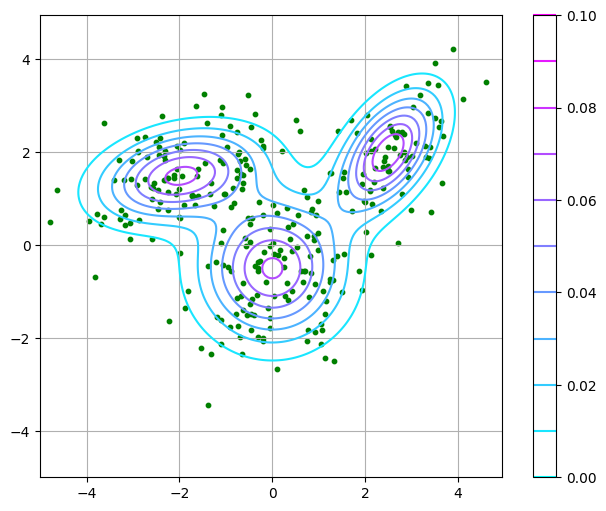

In [23]:
# データ分布とデータ点の可視化
NUM_SAMPLES = 300

x = np.arange(-5, 5, 0.05)  # x軸
y = np.arange(-5, 5, 0.05)  # y軸

X, Y = np.meshgrid(x, y)  # ともに ( 200, 200 )

Z = np.zeros_like(X)
for num in range(len(pi_data_list)):
    # すべての格子点についてまとめてdensityを計算するとメモリ不足になる
    for i in range(X.shape[0]):
        for j in range(Y.shape[1]):
            Z[i][j] += pi_data_list[num] * gaussian_density(
                np.array([X[i][j], Y[i][j]]),
                mu_data_list[num],
                sigma_data_inv_list[num],
                sigma_data_det_list[num],
            )

fig, ax = plt.subplots(figsize=(8.0, 6.0))
cont10 = ax.contour(X, Y, Z, levels=[0.01 * i for i in range(11)], cmap="cool")

data_plot = plt.scatter(
    data_all.T[0, :NUM_SAMPLES], data_all.T[1, :NUM_SAMPLES], s=10, c="g"
)
ax.set_aspect("equal", "box")
plt.colorbar(cont10)
plt.grid(True)
plt.show()

### 3.2 全データ点に対する，混合ガウス分布の対数尤度

混合ガウス分布の対数尤度も，混合ベルヌーイ分布の場合と同様に計算でます．

データ点の数を$N$，混合数を$K$，ガウス分布を$N({\bf x}; {\bf \mu},\Sigma)$とすると，全データ点に対する混合ガウス分布の対数尤度は，

$$
{\rm log}\  p_{\mu,\Sigma}({\rm X})= \sum_{i=1}^N{\rm log}\sum_{k=1}^K\pi_k\ \mathcal{N}({\bf x}_i; {\bf \mu}_k, \Sigma_k)
$$

で表されます．

In [24]:
def log_likelihood(
    data_all: np.ndarray, mu_list: np.ndarray, sigma_list: np.ndarray, pi_list: list
) -> float:
    """
    全データ点に対する，混合ガウス分布の対数尤度を計算する関数．

    Parameters
    ----------
    data_all : np.ndarray (3000, 2)
        すべてのデータ点をまとめた配列．
    mu_list : list [ (2), (2), (2) ]
        各多次元ガウス分布のパラメータ（平均値）．
    sigma_list : list [ (2, 2), (2, 2), (2, 2) ]
        各多次元ガウス分布のパラメータ（分散共分散行列）．
    pi_list : list (3, )
        混合率をまとめたリスト．

    Returns
    -------
    log_likely_all : float
        全データ点に対する混合ガウス分布の対数尤度．
    """
    sigma_inv_list = [np.linalg.inv(sigma) for sigma in sigma_list]
    sigma_det_list = [np.linalg.det(sigma) for sigma in sigma_list]
    log_likely_all = 0
    for data in data_all:
        likely = 0
        for k in range(len(pi_list)):
            likely += pi_list[k] * gaussian_density(
                data, mu_list[k], sigma_inv_list[k], sigma_det_list[k]
            )
        log_likely_all += np.log(likely)

    return log_likely_all

### 3.3 負担率

負担率も混合ベルヌーイ分布の場合と同様に，

$i$番目のデータ点に対する，$k$番目の潜在変数$z_{ik}$とすると，負担率は，

$$
p_{{\bf \mu},\Sigma,\pi}(z_{ik}=1|{\bf x}_i)
= \frac{\pi_k\ \mathcal{N}({\bf x}_i; {\bf \mu}_k, \Sigma_k)}{\sum_{j=1}^K\pi_j\ \mathcal{N}({\bf x}_i; {\bf \mu}_j, \Sigma_j)}
\equiv \gamma(z_{ik})
$$

で表されます．

In [25]:
def responsibility(
    data_all: np.ndarray, mu_list: list, sigma_list: list, pi_list: list
) -> np.ndarray:
    """
    負担率を計算する関数．

    Parameters
    ----------
    data_all : np.ndarray (3000, 2)
        すべてのデータ点をまとめた配列．
    mu_list : list [ (2), (2), (2) ]
        各多次元ガウス分布のパラメータ（平均値）．
    sigma_list : list [ (2, 2), (2, 2), (2, 2) ]
        各多次元ガウス分布のパラメータ（分散共分散行列）．
    pi_list : list (3, )
        混合率をまとめたリスト．

    Returns
    -------
    gamma_mat : np.ndarray (3000, 3)
        各データの負担率．
    """
    sigma_inv_list = [np.linalg.inv(sigma) for sigma in sigma_list]
    sigma_det_list = [np.linalg.det(sigma) for sigma in sigma_list]

    gamma_mat = np.zeros((data_all.shape[0], len(pi_list)))  # ( 3000, 3 )
    for i in range(gamma_mat.shape[0]):
        for k in range(gamma_mat.shape[1]):
            gamma_mat[i][k] = pi_list[k] * gaussian_density(
                data_all[i], mu_list[k], sigma_inv_list[k], sigma_det_list[k]
            )
        gamma_mat[i] /= np.sum(gamma_mat[i])
    return gamma_mat

In [26]:
def visualization(
    data_all: np.ndarray, mu_list: list, sigma_inv_list: list, sigma_det_list: list
) -> None:
    """
    学習時の可視化を行う関数．

    Parameters
    ----------
    data_all : np.ndarray (3000, 2)
        すべてのデータ点をまとめた配列．
    mu_list : list [ (2), (2), (2) ]
        各多次元ガウス分布のパラメータ（平均値）．
    sigma_inv_list : list [ (2, 2), (2, 2), (2,2) ]
        各多次元ガウス分布の分散共分散行列の逆行列．
    sigma_det_list : list [3, ]
        各多次元ガウス分布の分散共分散行列の行列式．

    Returns
    -------
    None
    """
    x = np.arange(-5, 5, 0.05)  # x軸
    y = np.arange(-5, 5, 0.05)  # y軸

    X, Y = np.meshgrid(x, y)

    Z = np.zeros_like(X)
    for num in range(len(pi_data_list)):
        for i in range(X.shape[0]):
            for j in range(Y.shape[1]):
                Z[i][j] += pi_list[num] * gaussian_density(
                    np.array([X[i][j], Y[i][j]]),
                    mu_list[num],
                    sigma_inv_list[num],
                    sigma_det_list[num],
                )

    fig, ax = plt.subplots(figsize=(6.0, 4.5))
    data_plot = ax.scatter(data_all.T[0][0:300], data_all.T[1][0:300], s=7, c="g")

    for k in range(len(mu_list)):
        ax.scatter(mu_list[k][0], mu_list[k][1], s=60, c="r", marker="x")

    ax.set_aspect("equal", "box")
    cont10 = ax.contour(X, Y, Z, levels=[0.01 * i for i in range(11)], cmap="cool")

    plt.colorbar(cont10)
    plt.title("step:{}".format(n_iter))
    plt.grid(True)

    plt.show()

### 3.4 学習

混合ガウス分布に対しても，EMアルゴリズムの基本的な流れは混合ベルヌーイ分布の場合と同じです．しかし，Mステップにおけるパラメータの更新において，共分散行列の更新も行う必要があります．

更新式は以下で表されます（証明等は[こちら](https://qiita.com/kenmatsu4/items/59ea3e5dfa3d4c161efb)などを参照してください）．

$$
\hat{\pi}_k = \frac{N_k}{N}
$$

$$
\hat{\bf \mu}_k = \frac{1}{N_k}\sum_{i=1}^N\gamma(z_{ik}){\bf x}_i
$$

$$
\hat{\Sigma}_k = \frac{1}{N_k}\sum_{i=1}^N\gamma(z_{ik})({\bf x}_i - \hat{\bf \mu}_k)({\bf x}_i - \hat{\bf \mu}_k)^T
$$

$$
ただし，
N_k = \sum_{n=1}^N\gamma(z_{ik})
$$

$\hat{\pi}_k$は全データの負担率の平均値，$\hat{\bf \mu}_k$は各データ点の負担率による重み付き平均値，$\hat{\Sigma}_k$は各データ点の負担率による重み付き共分散に相当します．


Iteration: 0, log_likelihood: -5.83954026298708


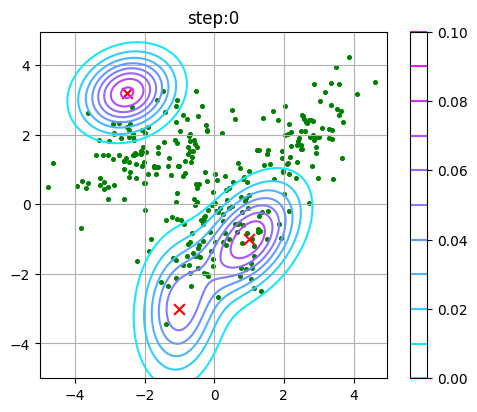

Iteration: 1, log_likelihood: -3.829253874512625


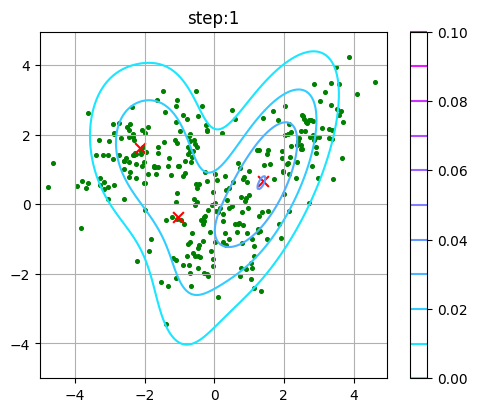

Iteration: 2, log_likelihood: -3.596011472348803


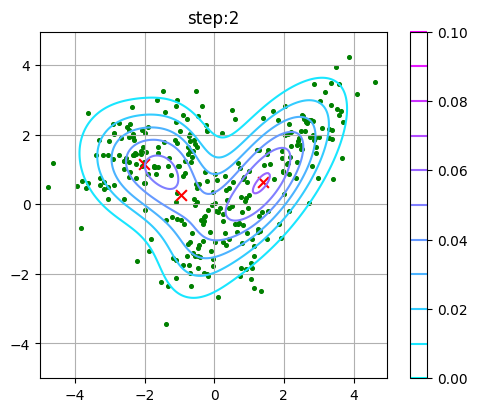

Iteration: 3, log_likelihood: -3.5706611584573027


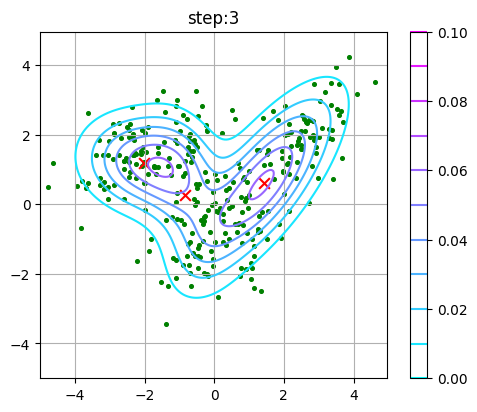

Iteration: 4, log_likelihood: -3.559488485745432


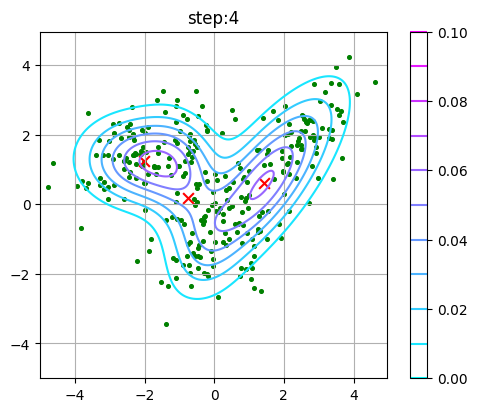

Iteration: 5, log_likelihood: -3.5504282204516677


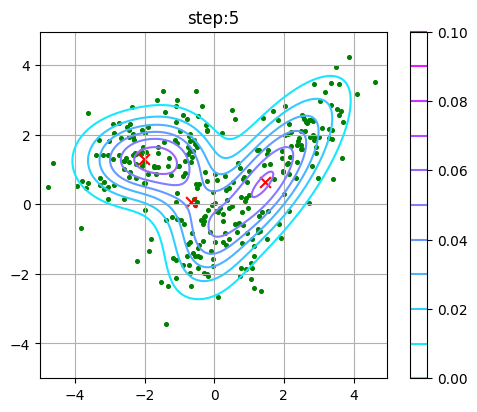

Iteration: 6, log_likelihood: -3.5416090169678416


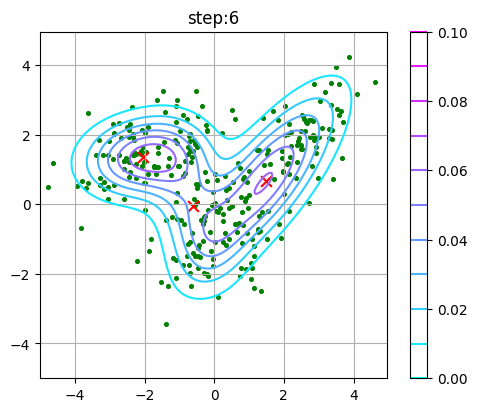

Iteration: 7, log_likelihood: -3.532791912171276


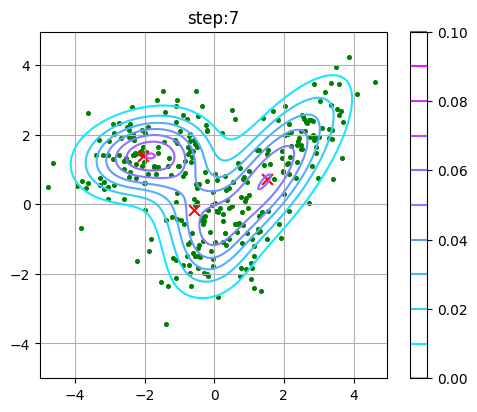

Iteration: 8, log_likelihood: -3.5241714632978653


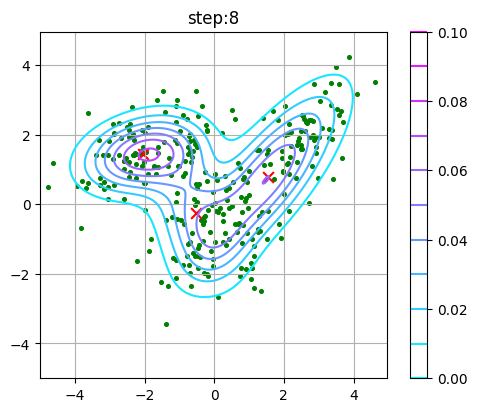

Iteration: 9, log_likelihood: -3.5161416077124628


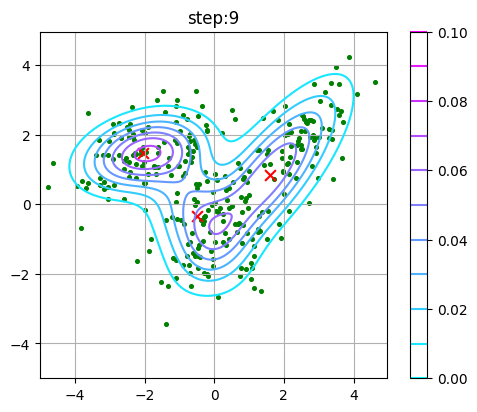

Iteration: 10, log_likelihood: -3.5092932326815784


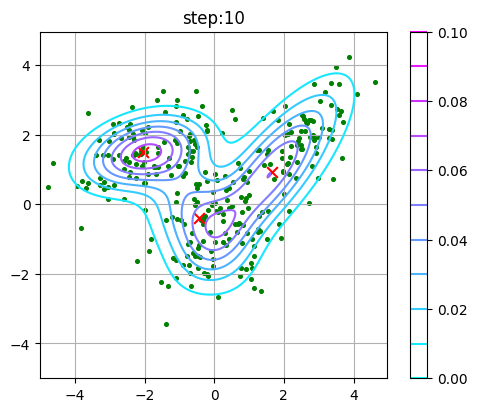

Iteration: 11, log_likelihood: -3.503998629400999


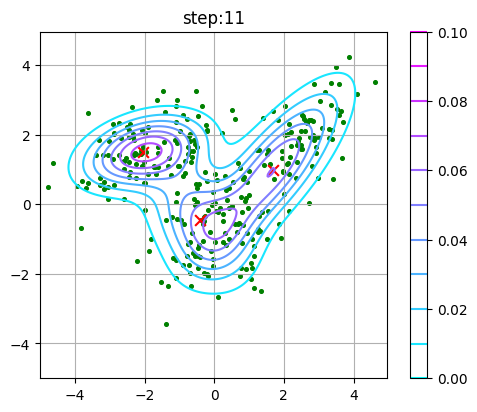

Iteration: 12, log_likelihood: -3.5000533835910477


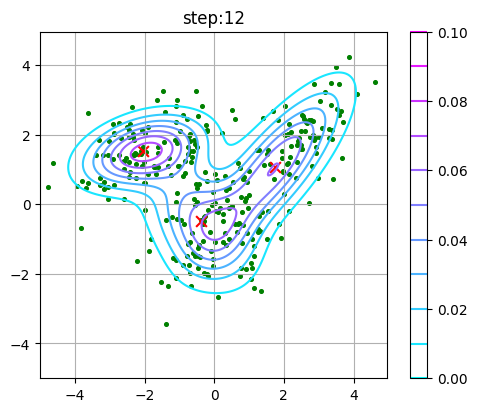

Iteration: 13, log_likelihood: -3.49699248184222


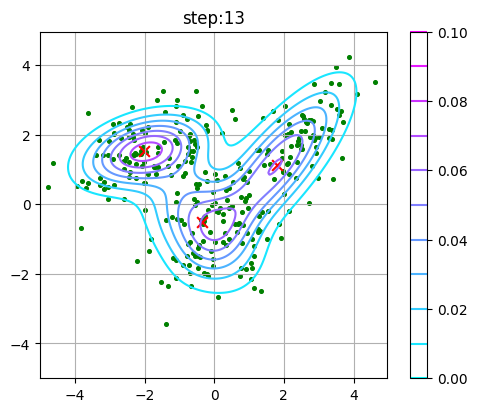

Iteration: 14, log_likelihood: -3.494390086798119


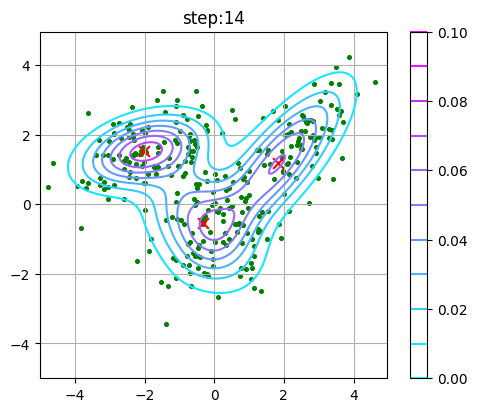

Iteration: 15, log_likelihood: -3.49194176748412


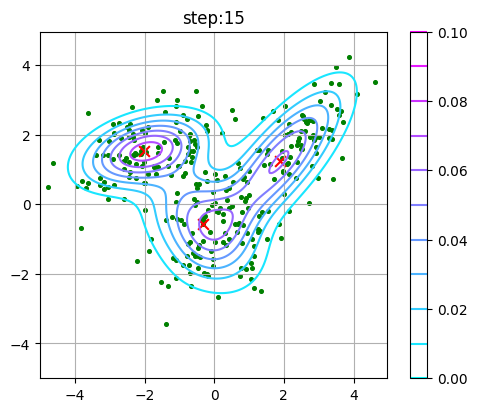

Iteration: 16, log_likelihood: -3.489452511078847


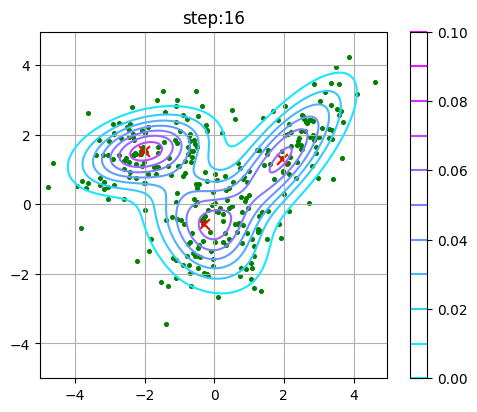

Iteration: 17, log_likelihood: -3.486818406851896


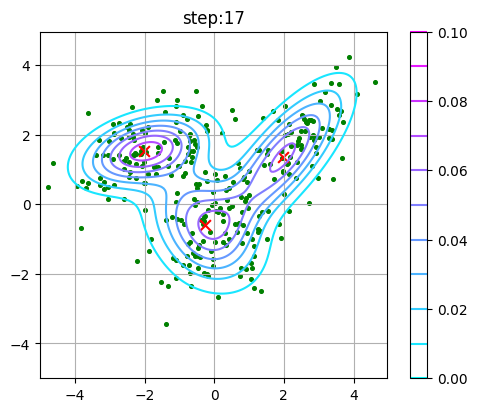

Iteration: 18, log_likelihood: -3.4840169172807256


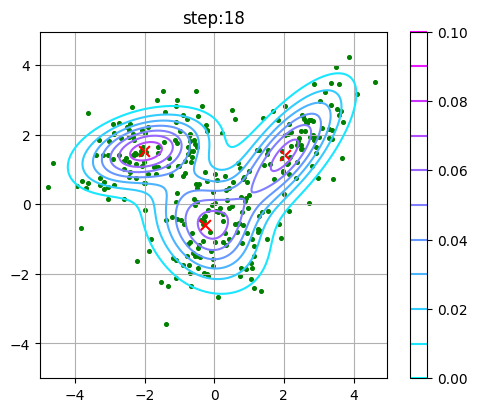

Iteration: 19, log_likelihood: -3.481091321921012


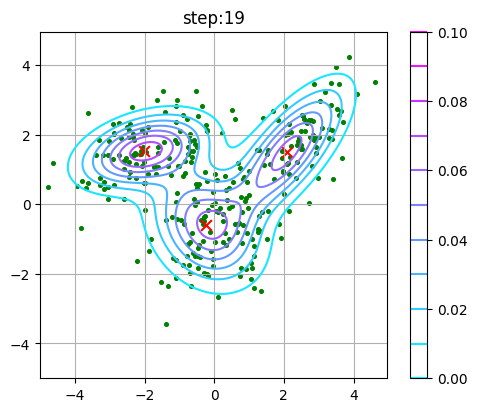

Iteration: 20, log_likelihood: -3.4781270859579387


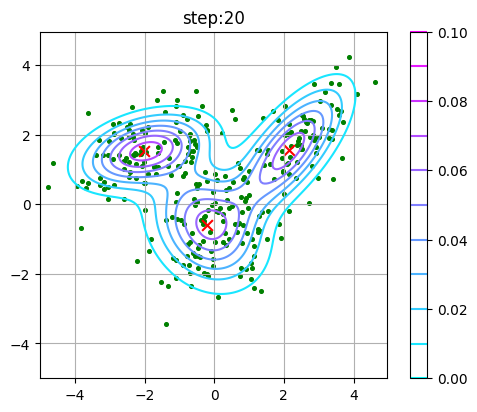

Iteration: 21, log_likelihood: -3.475229693259047


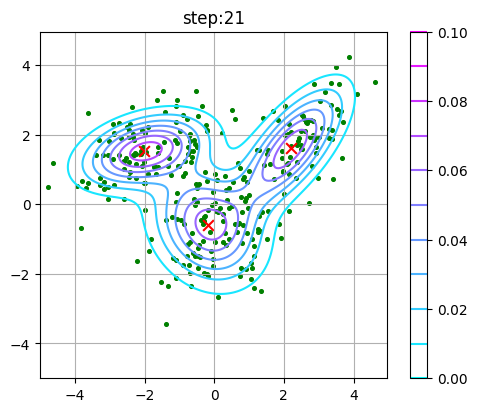

Iteration: 22, log_likelihood: -3.472507366386651


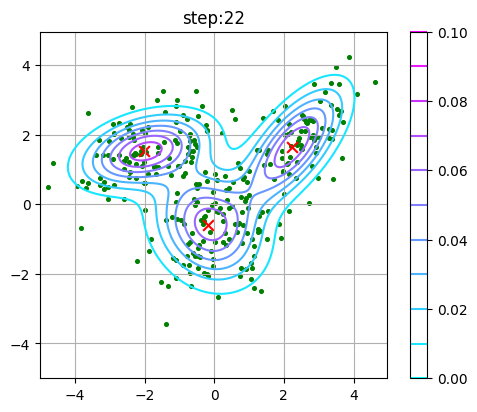

Iteration: 23, log_likelihood: -3.470056748531401


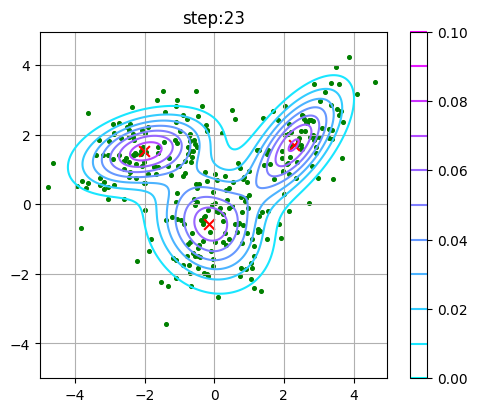

Iteration: 24, log_likelihood: -3.4679499515931598


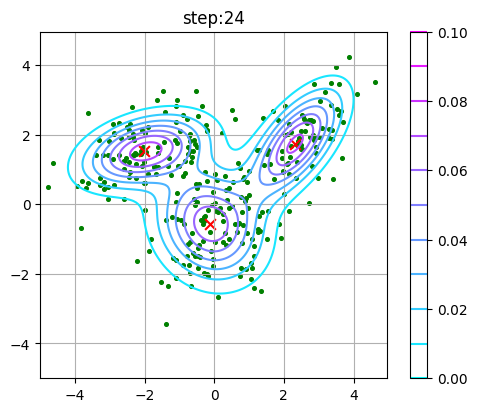

Iteration: 25, log_likelihood: -3.466224028346783


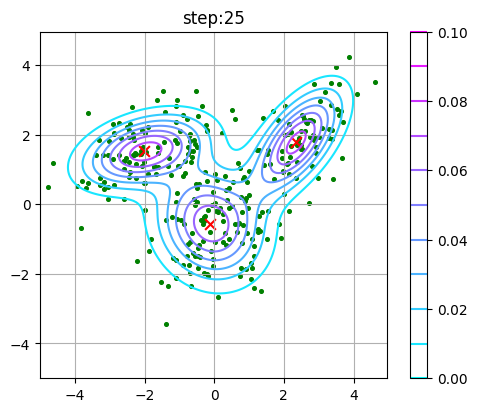

Iteration: 26, log_likelihood: -3.4648766857588287


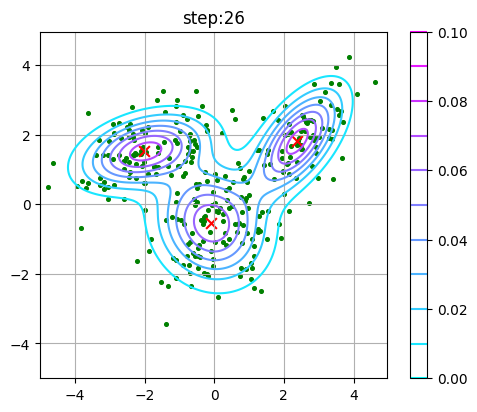

Iteration: 27, log_likelihood: -3.46387138665119


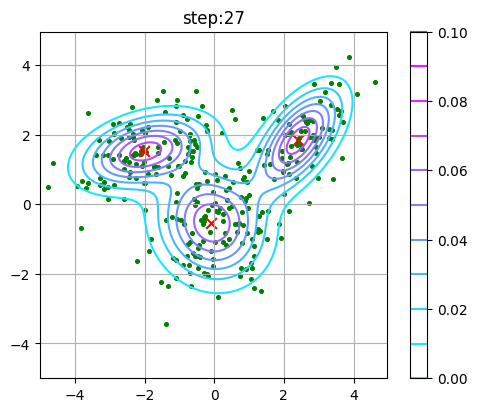

Iteration: 28, log_likelihood: -3.4631502947734223


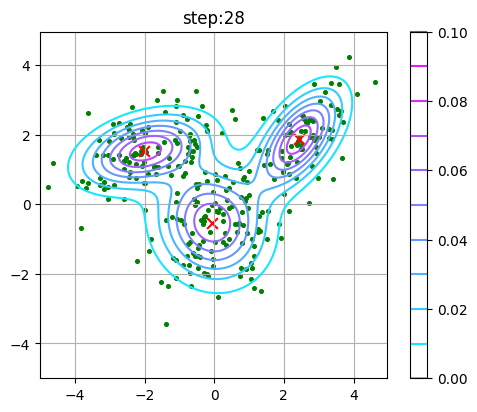

Iteration: 29, log_likelihood: -3.462649279480596


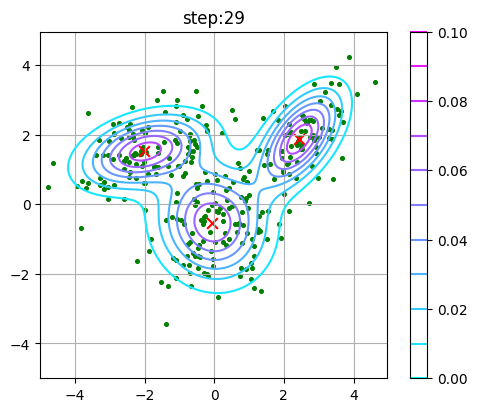

Iteration: 30, log_likelihood: -3.4623093710990323


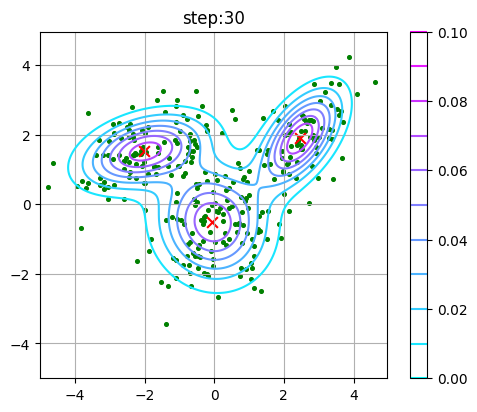

Iteration: 31, log_likelihood: -3.4620825172403533


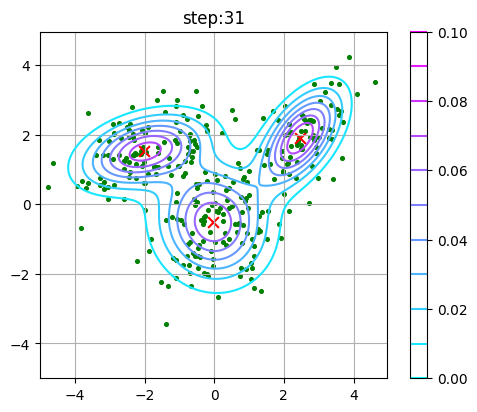

Iteration: 32, log_likelihood: -3.4619326450234498


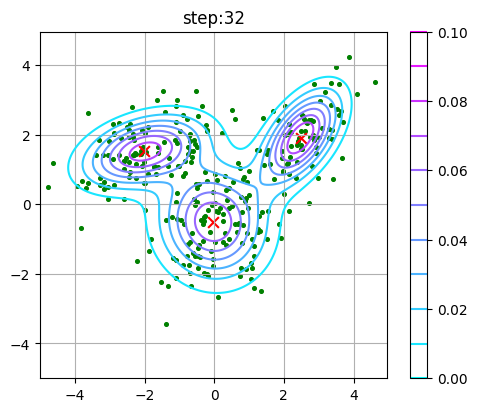

Iteration: 33, log_likelihood: -3.4618341418939873


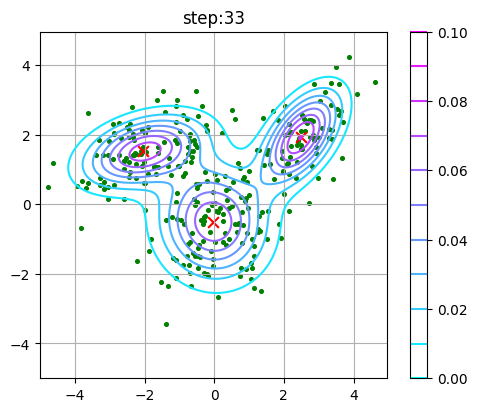

In [27]:
# パラメータ初期化 (適当な値で初期化)
mu0 = np.array([-1, -3])
sigma0 = np.array([[0.5, 0.1], [0.1, 1.5]])

mu1 = np.array([-2.5, 3.2])
sigma1 = np.array([[0.7, 0.1], [0.1, 0.5]])

mu2 = np.array([1, -1])
sigma2 = np.array([[0.8, 0.4], [0.4, 1.0]])

mu_list = [mu0, mu1, mu2]
sigma_list = [sigma0, sigma1, sigma2]
sigma_inv_list = [np.linalg.inv(sigma) for sigma in sigma_list]
sigma_det_list = [np.linalg.det(sigma) for sigma in sigma_list]
pi_list = [0.3, 0.3, 0.4]


n_iter = 0

likely = log_likelihood(data_all, mu_list, sigma_list, pi_list) / NUM_DATA
print("Iteration: {0}, log_likelihood: {1}".format(n_iter, likely))
visualization(data_all, mu_list, sigma_inv_list, sigma_det_list)


# 下がり幅がth以下になったら収束したと判定する
th = 0.0001

# 学習
while True:
    n_iter += 1

    # Eステップ（負担率計算）
    gamma_mat = responsibility(data_all, mu_list, sigma_list, pi_list)  # ( 3000, 3 )
    n_k = np.sum(gamma_mat, axis=0)

    # Mステップ（パラメータ更新）
    # piの新しい推定量
    pi_list_next = (n_k / n_k.sum()).tolist() # .tolist()

    # gamma_mat: ( 3000, 3 ) data_all: ( 3000, 2 ) n_k: ( 3, )
    mu_list_next = (data_all.T @ gamma_mat / n_k).T # ( 3, 2 )
    # muの新しい推定量
    mu_list_next = list(mu_list_next)  # [( 2, ), ( 2, ), ( 2, )]

    # Sigmaの新しい推定量
    sigma_list_next = []
    for k in range(len(pi_list)):
        sigma_k = np.zeros_like(sigma_list[k], dtype=float)

        for n in range(data_all.shape[0]):
            sigma_k += gamma_mat[n][k] * np.matmul(
                (data_all[n:n+1] - mu_list[k:k+1]).T,
                (data_all[n:n+1] - mu_list[k:k+1]),
            )

        sigma_list_next.append(sigma_k / n_k[k])

    mu_list = copy.deepcopy(mu_list_next)
    sigma_list = copy.deepcopy(sigma_list_next)
    pi_list = copy.deepcopy(pi_list_next)

    sigma_inv_list = [np.linalg.inv(sigma) for sigma in sigma_list]
    sigma_det_list = [np.linalg.det(sigma) for sigma in sigma_list]

    likely_before = likely

    likely = log_likelihood(data_all, mu_list, sigma_list, pi_list) / NUM_DATA

    print("Iteration: {0}, log_likelihood: {1}".format(n_iter, likely))

    visualization(data_all, mu_list, sigma_inv_list, sigma_det_list)

    delta = likely - likely_before
    if delta < th:
        break

## 4. 参考文献
[[1]](https://www.jstor.org/stable/2984875) Dempster, A. P., N. M. Laird, and D. B. Rubin. “Maximum Likelihood from Incomplete Data via the EM Algorithm.” Journal of the Royal Statistical Society. Series B (Methodological) 39, no. 1 (1977): 1–38.